<a href="https://colab.research.google.com/github/Vineelag2122/Machine-Learning/blob/main/Linear_Regression_End_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Linear Regression with my own dataset**

the dataset i have taken is used to find student performace . it has columns -

* Hours Studied(Numeric)

* Previous Scores(Numeric)

* Extracurricular Activities(Categorical)

* Sleep Hours(Numeric)

* Sample Question Papers Practiced(Numeric)

* Performance Index(Target Variable)

dataset : Student Performance (Multiple Linear Regression)

source:kaggle

rows:10,000

columns:6

Performance Index is the target variable.

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

import joblib

# Load the CSV (change filename/path as needed)
df = pd.read_csv('/content/Student_Performance.csv')
df.columns = df.columns.str.strip()   # clean column names
df.head()


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [ ]:
print("Shape:", df.shape)
print("===================================")
print("\nInfo:")
print(df.info())
print("\n===================================")
print("\nDescribe:")
print(df.describe().T)
print("\n===================================")
print("\nMissing values per column:")
print(df.isnull().sum())
print("\n===================================")
print("\nDuplicate rows:", df.duplicated().sum())
df.shape

Shape: (10000, 6)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB
None


Describe:
                                    count     mean        std   min   25%  \
Hours Studied                     10000.0   4.9929   2.589309   1.0   3.0   
Previous Scores                   10000.0  69.4457  17.343152  40.0  54.0   
Sleep Hours                       10000.0   6.5306  

(10000, 6)

In [ ]:
# === Preprocessing Cell ===

from sklearn.preprocessing import StandardScaler
print(df.shape)
# 1. Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print("Column names standardized:", df.columns.tolist())
print("\n===================================")

print(df.shape)
# 2. Remove duplicates
before = df.shape[0]
print(before)
df = df.drop_duplicates().reset_index(drop=True)
after = df.shape[0]
print(after)
print(f"Removed {before-after} duplicate rows. New record count = {after}")
print(df.shape)
print("\n===================================")

# 3. List columns with missing values
missing = df.isnull().sum()
print("\nMissing values per column:\n", missing[missing > 0])
print("\n===================================")

# 4. Imputation: numeric = median, categorical = most frequent
for col in df.columns:
    if df[col].dtype in ['int64','float64']:
        df[col] = df[col].fillna(df[col].median())
    else:  # categorical
        df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after imputation:\n", df.isnull().sum().sum())
print("\n===================================")

# 5. Encoding: 'extracurricular_activities' (Yes/No → 1/0)
if 'extracurricular_activities' in df.columns:
    df['extracurricular_activities'] = df['extracurricular_activities'].map({'Yes':1, 'No':0})


# 6. Scaling: StandardScaler for numeric features (not target)
features = df.drop('performance_index', axis=1)
target = df['performance_index']

numeric_cols = features.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
features_scaled = features.copy()
features_scaled[numeric_cols] = scaler.fit_transform(features[numeric_cols])

# 7. Outlier handling (IQR method on numeric features)
def remove_outliers_iqr(data, cols):
    cleaned = data.copy()
    for col in cols:
        Q1 = cleaned[col].quantile(0.25)
        Q3 = cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR
        cleaned = cleaned[(cleaned[col] >= lower) & (cleaned[col] <= upper)]
    return cleaned

df_outliers_removed = remove_outliers_iqr(df, numeric_cols)
print(f"\nRecord count after outlier removal: {df_outliers_removed.shape[0]} (was {df.shape[0]})")

# 8. Feature selection/dropping (example: if we drop 'sleep_hours' because weak correlation)
# In real assignment: explain reason (low correlation, redundancy, leakage)
# features_scaled = features_scaled.drop('sleep_hours', axis=1)

# 9. Leakage check
print("\nLeakage check performed: Yes. Target variable (performance_index) is NOT used in features.")

# Final processed dataset
X = features_scaled
y = target

print("\nFinal feature columns:", X.columns.tolist())
print("Target variable:", y.name)
print("Final dataset shape:", X.shape, y.shape)
df.head()


(10000, 6)
Column names standardized: ['hours_studied', 'previous_scores', 'extracurricular_activities', 'sleep_hours', 'sample_question_papers_practiced', 'performance_index']

(10000, 6)
10000
9873
Removed 127 duplicate rows. New record count = 9873
(9873, 6)


Missing values per column:
 Series([], dtype: int64)


Missing values after imputation:
 0


Record count after outlier removal: 9873 (was 9873)

Leakage check performed: Yes. Target variable (performance_index) is NOT used in features.

Final feature columns: ['hours_studied', 'previous_scores', 'extracurricular_activities', 'sleep_hours', 'sample_question_papers_practiced']
Target variable: performance_index
Final dataset shape: (9873, 5) (9873,)


,hours_studied,previous_scores,extracurricular_activities,sleep_hours,sample_question_papers_practiced,performance_index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


In [ ]:
print(X.head())
print(y.head())

   hours_studied  previous_scores  extracurricular_activities  sleep_hours  \
0       0.775566         1.706168                    1.010078     1.454025   
1      -0.383205         0.724912                   -0.990022    -1.491315   
2       1.161822        -1.064438                    1.010078     0.275889   
3       0.003052        -1.006717                    1.010078    -0.902247   
4       0.775566         0.320865                   -0.990022     0.864957   

   sample_question_papers_practiced  
0                         -1.249715  
1                         -0.900925  
2                         -0.900925  
3                         -0.900925  
4                          0.145444  
0    91.0
1    65.0
2    45.0
3    36.0
4    66.0
Name: performance_index, dtype: float64


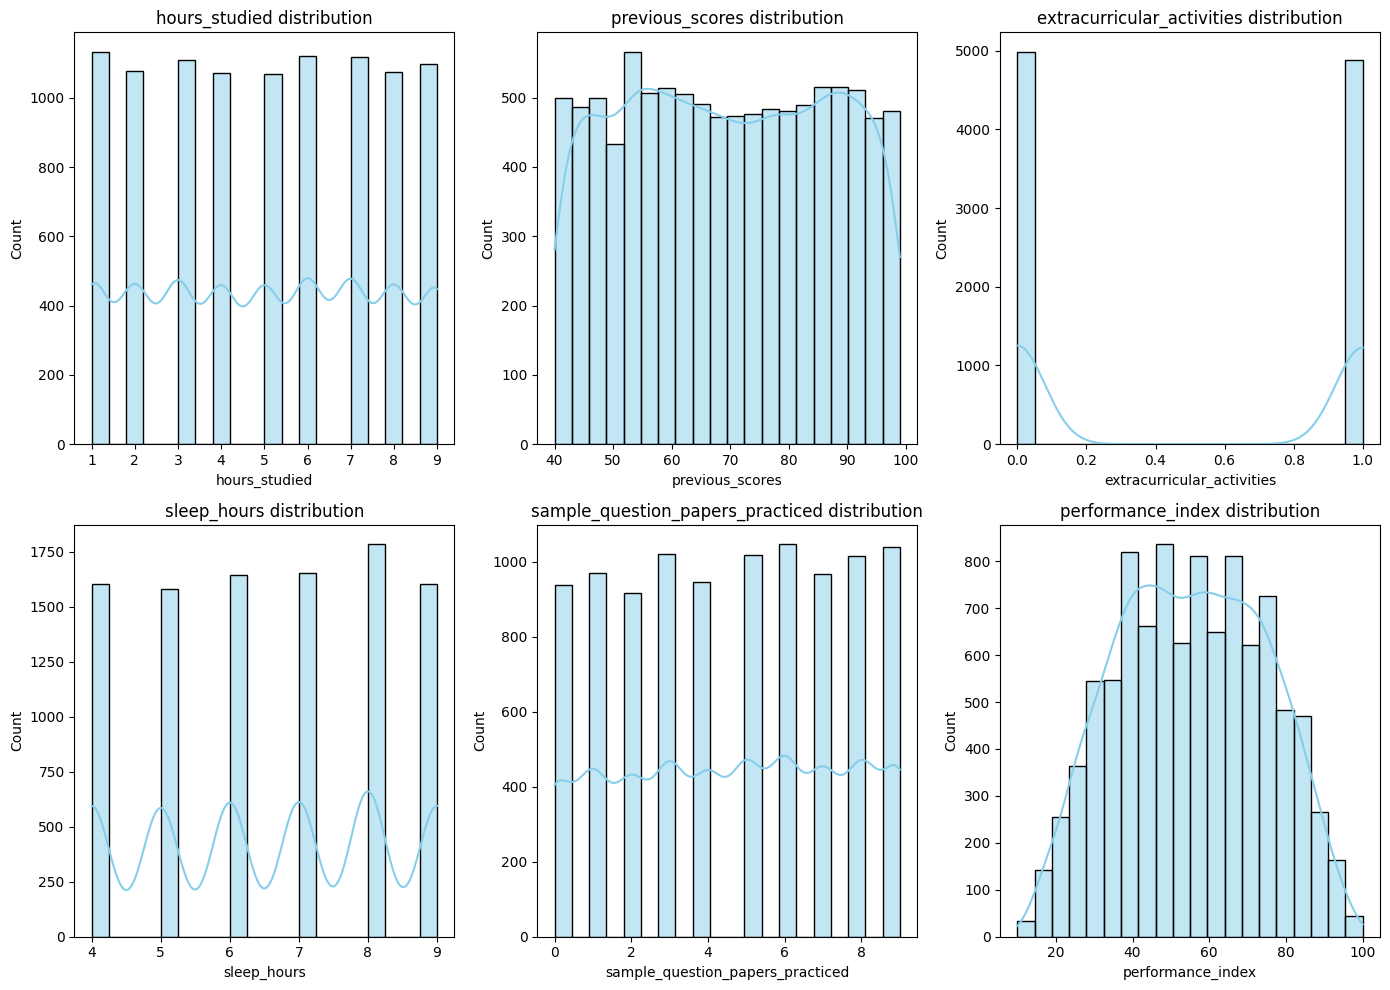

Skewness of numeric columns:
 extracurricular_activities          0.020059
previous_scores                     0.005581
performance_index                  -0.000412
hours_studied                      -0.003348
sample_question_papers_practiced   -0.034893
sleep_hours                        -0.041350
dtype: float64


In [ ]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns

plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=20, color='skyblue')
    plt.title(f"{col} distribution")
plt.tight_layout()
plt.show()

# Skewness values for numeric features
skewness = df[numeric_cols].skew().sort_values(ascending=False)
print("Skewness of numeric columns:\n", skewness)

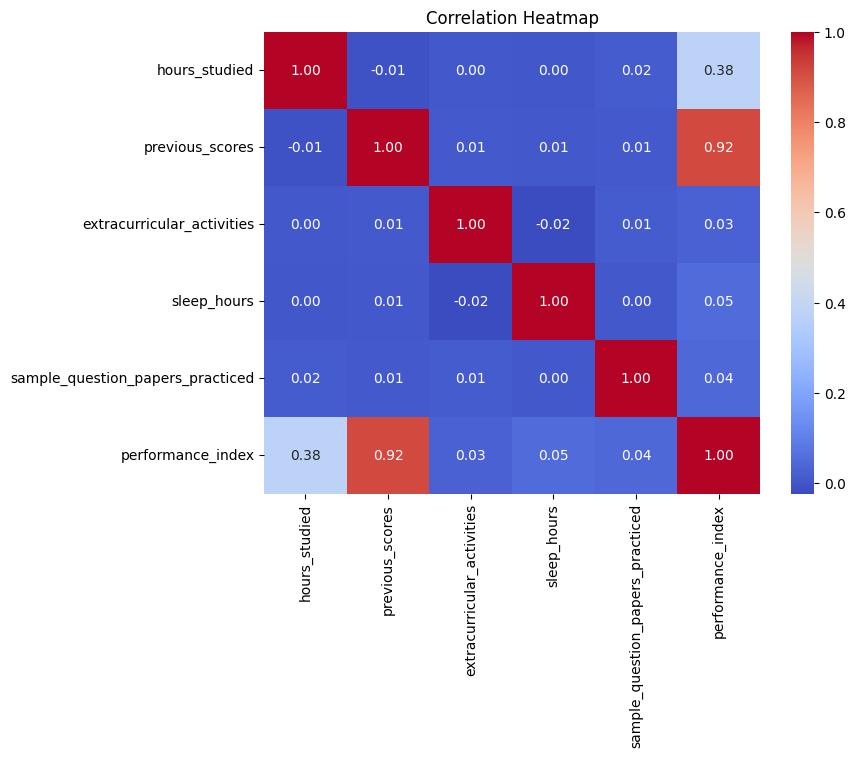

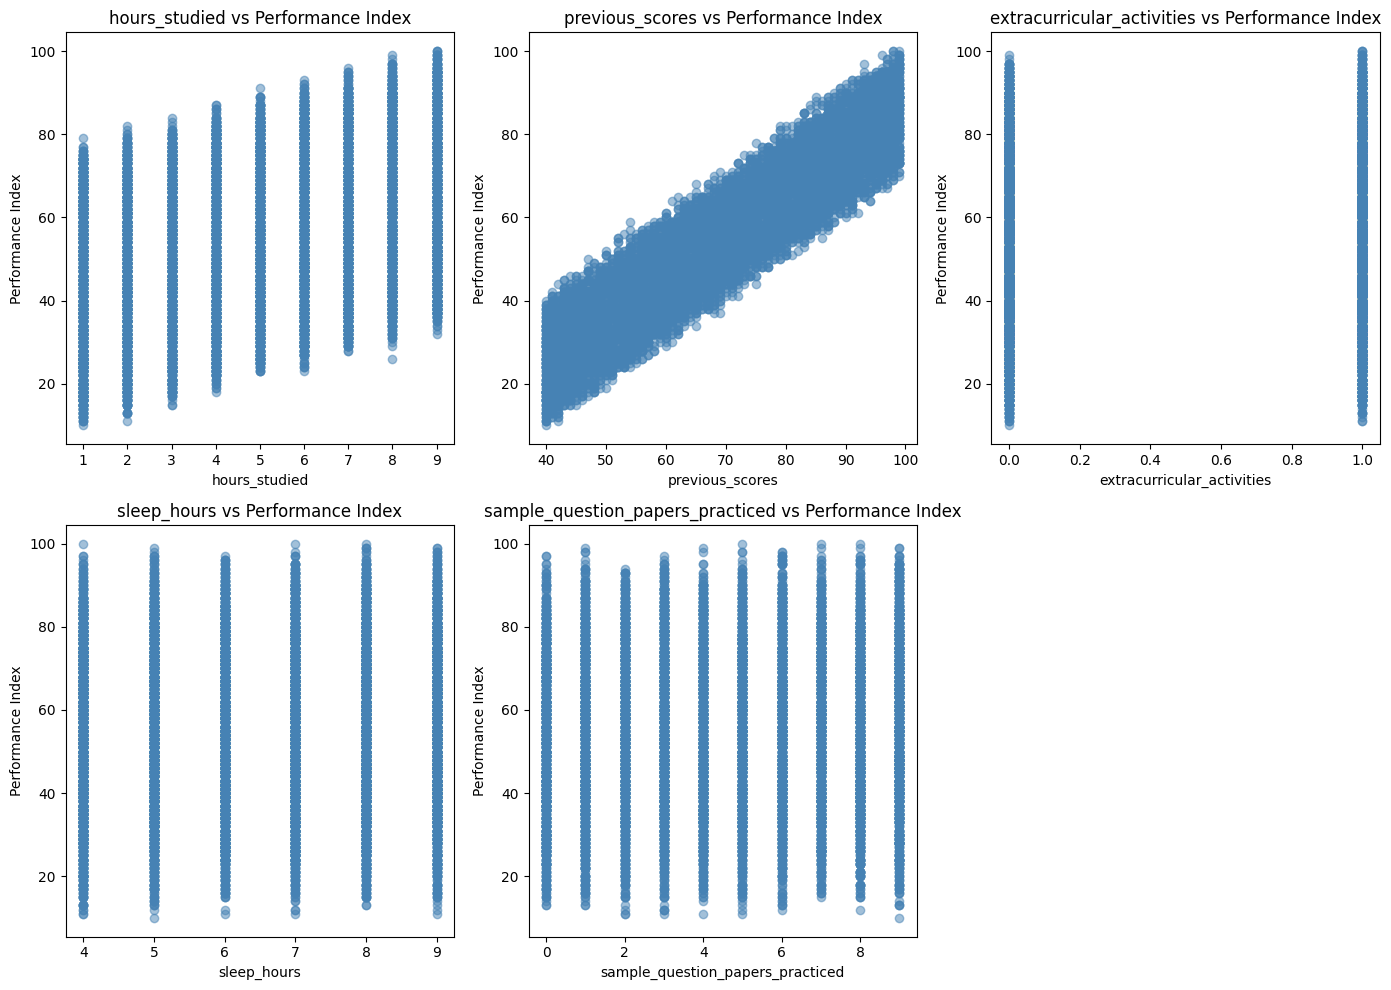

In [ ]:
# === EDA: Multivariate ===

# 1. Correlation heatmap (numerical features + target)
plt.figure(figsize=(8,6))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# 2. Scatter plots of features vs target
numeric_features = df.drop('performance_index', axis=1).select_dtypes(include=['int64','float64']).columns

plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    plt.scatter(df[col], df['performance_index'], alpha=0.5, color="steelblue")
    plt.xlabel(col)
    plt.ylabel("Performance Index")
    plt.title(f"{col} vs Performance Index")
plt.tight_layout()
plt.show()


In [ ]:
print(df.shape)
df.head(10)

(9873, 6)


,hours_studied,previous_scores,extracurricular_activities,sleep_hours,sample_question_papers_practiced,performance_index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0
5,3,78,0,9,6,61.0
6,7,73,1,5,6,63.0
7,8,45,1,4,6,42.0
8,5,77,0,8,2,61.0
9,4,89,0,4,0,69.0


In [ ]:
# 1. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Fit Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# 3. Predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# 4. Metrics
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2_test = r2_score(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
gap = r2_train - r2_test

print("Linear Regression — Metrics")
print(f"MAE  : {mae:.3f}")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R² (Test): {r2_test:.3f}")
print(f"R² (Train): {r2_train:.3f}")
print(f"Train–Test Gap: {gap:.3f}")

# Short comment
if abs(gap) < 0.05:
    comment = "Model generalizes well (no major overfitting/underfitting)."
elif gap > 0.05:
    comment = "Model may be overfitting (Train R² much higher than Test)."
else:
    comment = "Model may be underfitting (both R² are low)."

print("Comment:", comment)


Linear Regression — Metrics
MAE  : 1.647
MSE  : 4.306
RMSE : 2.075
R² (Test): 0.988
R² (Train): 0.989
Train–Test Gap: 0.000
Comment: Model generalizes well (no major overfitting/underfitting).


In [ ]:
import pandas as pd

# Get feature names and coefficients
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print(coef_df)

                            Feature  Coefficient
1                   previous_scores    17.644024
0                     hours_studied     7.381153
3                       sleep_hours     0.801390
4  sample_question_papers_practiced     0.541024
2        extracurricular_activities     0.286897


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# Add constant for statsmodels
X_const = X.copy()
X_const['Intercept'] = 1

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i)
                   for i in range(len(X.columns))]

# Sort top 3 VIFs
vif_data = vif_data.sort_values(by='VIF', ascending=False)
print("Top 3 VIFs:")
print(vif_data.head(3))

Top 3 VIFs:
                            Feature       VIF
2        extracurricular_activities  1.000888
3                       sleep_hours  1.000676
4  sample_question_papers_practiced  1.000540


In [ ]:
from scipy.stats import shapiro

residuals = y_train - lr.predict(X_train)
shapiro_test = shapiro(residuals)
print("Shapiro-Wilk test p-value:", shapiro_test.pvalue)
# p > 0.05 → residuals roughly normal


Shapiro-Wilk test p-value: 0.33468823766235833


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7898.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(residuals)
print("Durbin-Watson statistic:", dw)
# ~2 → no autocorrelation, <1 or >3 → correlation present


Durbin-Watson statistic: 1.9710260354070632


In [ ]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Fit model using statsmodels OLS for BP test
X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()

bp_test = het_breuschpagan(model_sm.resid, model_sm.model.exog)
# bp_test[1] is p-value
print("Breusch–Pagan test p-value:", bp_test[1])
# p > 0.05 → homoscedasticity holds


Breusch–Pagan test p-value: 0.8927149054877119


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

# Strongest feature
strong_feat = 'hours_studied'
X_poly_base = X[[strong_feat]]  # keep it 2D

best_degree = 1
best_cv_r2 = -np.inf

print("Polynomial Feature Tuning for:", strong_feat)
for degree in range(1, 6):  # try degree 1 to 5
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X_poly_base)

    lr = LinearRegression()
    # 5-fold cross-validation for R²
    cv_r2 = cross_val_score(lr, X_poly, y, cv=5, scoring='r2').mean()

    print(f"Degree {degree}: CV R² = {cv_r2:.4f}")

    if cv_r2 > best_cv_r2:
        best_cv_r2 = cv_r2
        best_degree = degree

print(f"\nBest degree: {best_degree}, Best CV R²: {best_cv_r2:.4f}")

# Fit on best degree
poly_best = PolynomialFeatures(degree=best_degree, include_bias=False)
X_poly_best = poly_best.fit_transform(X_poly_base)
lr_best = LinearRegression()
lr_best.fit(X_poly_best, y)

# Overfit / underfit note
if best_degree == 1:
    fit_note = "Linear model (degree 1) suffices; low complexity, no overfit."
elif best_degree >= 4:
    fit_note = "High-degree polynomial; risk of overfitting."
else:
    fit_note = "Moderate-degree polynomial; balanced fit."

print("Fit note:", fit_note)


Polynomial Feature Tuning for: hours_studied
Degree 1: CV R² = 0.1404
Degree 2: CV R² = 0.1404
Degree 3: CV R² = 0.1399
Degree 4: CV R² = 0.1399
Degree 5: CV R² = 0.1400

Best degree: 1, Best CV R²: 0.1404
Fit note: Linear model (degree 1) suffices; low complexity, no overfit.


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# ----- Version 1: No encoding -----
X_no_enc = X.copy()
# Revert encoded column back to strings if needed
if 'extracurricular_activities' in X_no_enc.columns:
    X_no_enc['extracurricular_activities'] = df['extracurricular_activities'].astype(str)

lr = LinearRegression()
cv_r2_no_enc = cross_val_score(lr, X_no_enc, y, cv=5, scoring='r2').mean()

# ----- Version 2: With encoding (already 1/0) -----
X_enc = X.copy()  # already encoded
cv_r2_enc = cross_val_score(lr, X_enc, y, cv=5, scoring='r2').mean()

# ----- Compare -----
print(f"R² without encoding: {cv_r2_no_enc:.4f}")
print(f"R² with encoding   : {cv_r2_enc:.4f}")

improved = "Y" if cv_r2_enc > cv_r2_no_enc else "N"
print("Encoding helped?:", improved)
if improved == "Y":
    reason = "Encoding turned categorical variable into numeric, allowing model to learn impact."
else:
    reason = "No improvement, maybe variable has low influence or numeric mapping did not help."
print("Reason:", reason)


R² without encoding: 0.9887
R² with encoding   : 0.9887
Encoding helped?: N
Reason: No improvement, maybe variable has low influence or numeric mapping did not help.


In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

In [ ]:
alpha_grid = [0.01, 0.1, 1, 10, 100]


In [ ]:
ridge = Ridge()
ridge_search = GridSearchCV(ridge, param_grid={'alpha': alpha_grid}, cv=5, scoring='r2')
ridge_search.fit(X_train, y_train)

best_ridge_alpha = ridge_search.best_params_['alpha']
ridge_r2_test = ridge_search.score(X_test, y_test)

print(f"Ridge Regression: Best alpha = {best_ridge_alpha}, R² (Test) = {ridge_r2_test:.4f}")


Ridge Regression: Best alpha = 0.01, R² (Test) = 0.9884


In [ ]:
lasso = Lasso(max_iter=10000)
lasso_search = GridSearchCV(lasso, param_grid={'alpha': alpha_grid}, cv=5, scoring='r2')
lasso_search.fit(X_train, y_train)

best_lasso_alpha = lasso_search.best_params_['alpha']
lasso_r2_test = lasso_search.score(X_test, y_test)
lasso_nonzero = np.sum(lasso_search.best_estimator_.coef_ != 0)

print(f"Lasso Regression: Best alpha = {best_lasso_alpha}, R² (Test) = {lasso_r2_test:.4f}, Non-zero Coefficients = {lasso_nonzero}")


Lasso Regression: Best alpha = 0.01, R² (Test) = 0.9884, Non-zero Coefficients = 5


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Define K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# R² CV
r2_scores = cross_val_score(lr, X, y, cv=kf, scoring='r2')
print(f"R² CV: mean = {r2_scores.mean():.4f}, std = {r2_scores.std():.4f}")

# RMSE CV (custom scorer)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)  # negative because scorer maximizes
rmse_scores = cross_val_score(lr, X, y, cv=kf, scoring=rmse_scorer)
rmse_scores = -rmse_scores  # convert back to positive
print(f"RMSE CV: mean = {rmse_scores.mean():.4f}, std = {rmse_scores.std():.4f}")

R² CV: mean = 0.9887, std = 0.0002
RMSE CV: mean = 2.0450, std = 0.0213


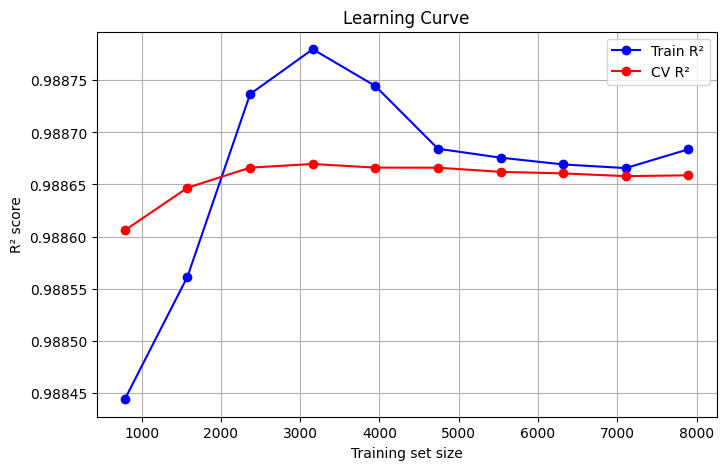

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    lr, X, y, cv=kf, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train R²')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='CV R²')
plt.xlabel('Training set size')
plt.ylabel('R² score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# 1. Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=42
)

# 2. Final model (Ridge chosen after F3)
final_model = Ridge(alpha=1)
final_model.fit(X_train, y_train)

# 3. Predictions on test set
y_test_pred_final = final_model.predict(X_test)

# 4. Final metrics
final_mae = mean_absolute_error(y_test, y_test_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_final))
final_r2 = final_model.score(X_test, y_test)

print(f"Final Model Metrics:\nMAE = {final_mae:.3f}\nRMSE = {final_rmse:.3f}\nR² (Test) = {final_r2:.3f}")

# 5. Top 3 drivers (largest absolute coefficients)
coef_df = pd.DataFrame({
    "Feature": X_enc.columns,
    "Coefficient": final_model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

top3_features = coef_df.head(3)
print("\nTop 3 Feature Drivers:")
print(top3_features)


Final Model Metrics:
MAE = 1.647
RMSE = 2.075
R² (Test) = 0.988

Top 3 Feature Drivers:
           Feature  Coefficient
1  previous_scores    17.641777
0    hours_studied     7.380198
3      sleep_hours     0.801304


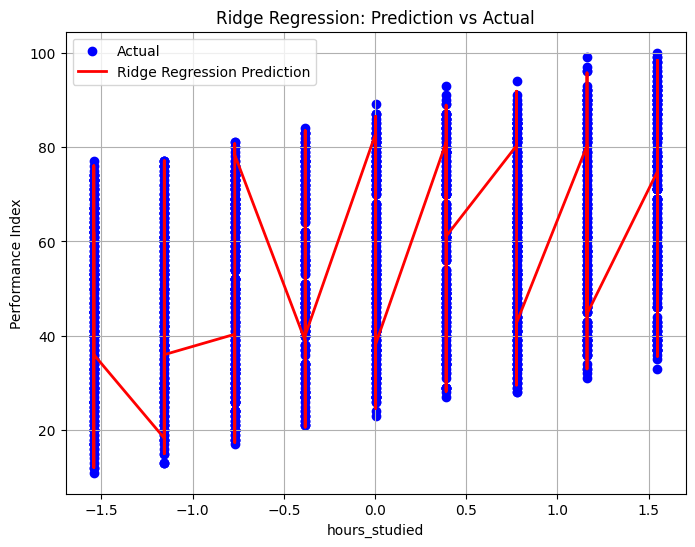

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Feature to plot
feature_to_plot = 'hours_studied'

# Create grid of values for plotting
X_grid = X_test.copy()
X_grid = X_grid.sort_values(feature_to_plot)

# Predict with Ridge model
y_pred = final_model.predict(X_grid)

plt.figure(figsize=(8,6))
plt.scatter(X_test[feature_to_plot], y_test, color='blue', label='Actual')
plt.plot(X_grid[feature_to_plot], y_pred, color='red', linewidth=2, label='Ridge Regression Prediction')
plt.xlabel(feature_to_plot)
plt.ylabel('Performance Index')
plt.title('Ridge Regression: Prediction vs Actual')
plt.legend()
plt.grid(True)
plt.show()


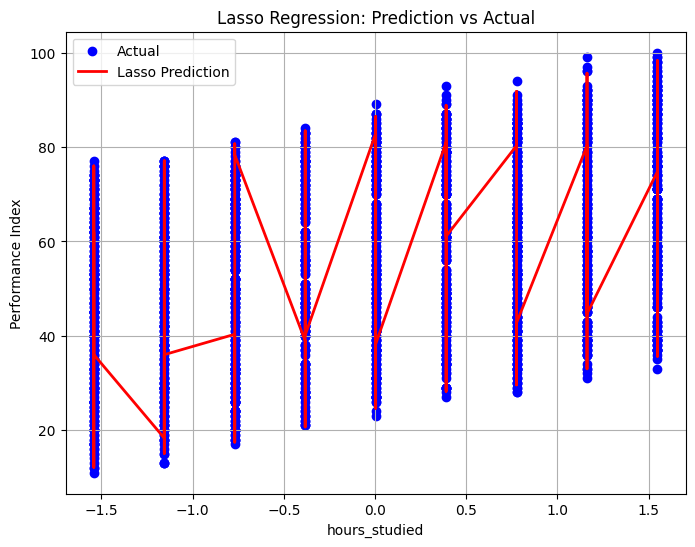

In [ ]:
import matplotlib.pyplot as plt

# Feature to plot
feature_to_plot = 'hours_studied'

# Sort test data for plotting
X_grid = X_test.copy()
X_grid = X_grid.sort_values(feature_to_plot)

# Predict using Lasso model
y_pred_lasso = lasso_search.best_estimator_.predict(X_grid)

plt.figure(figsize=(8,6))
plt.scatter(X_test[feature_to_plot], y_test, color='blue', label='Actual')
plt.plot(X_grid[feature_to_plot], y_pred_lasso, color='red', linewidth=2, label='Lasso Prediction')
plt.xlabel(feature_to_plot)
plt.ylabel('Performance Index')
plt.title('Lasso Regression: Prediction vs Actual')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


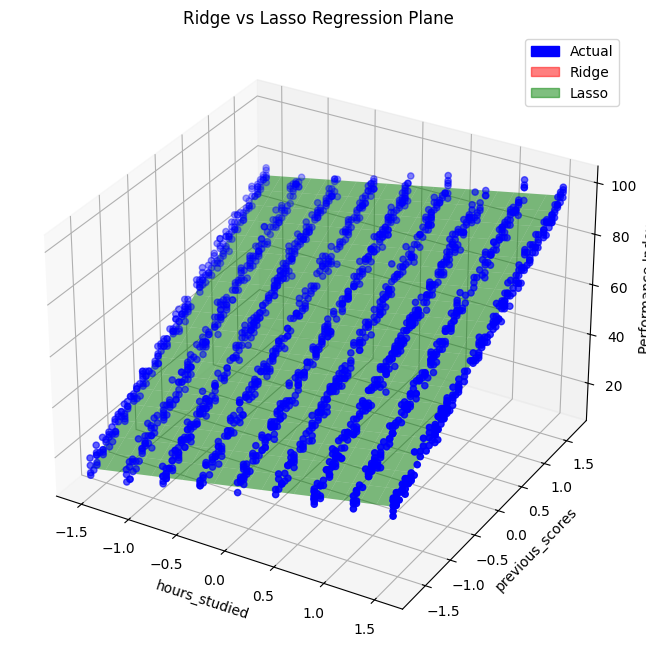

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import numpy as np

# Choose two features
feat_x = 'hours_studied'
feat_y = 'previous_scores'

# Prepare test data
X_plot = X_test[[feat_x, feat_y]]
y_plot = y_test.values

# Create meshgrid for plotting planes
x_surf, y_surf = np.meshgrid(
    np.linspace(X_plot[feat_x].min(), X_plot[feat_x].max(), 20),
    np.linspace(X_plot[feat_y].min(), X_plot[feat_y].max(), 20)
)

# Flatten meshgrid and create full input matrix
num_points = x_surf.ravel().shape[0]
X_mesh = np.zeros((num_points, X_test.shape[1]))
X_mesh[:, X_test.columns.get_loc(feat_x)] = x_surf.ravel()
X_mesh[:, X_test.columns.get_loc(feat_y)] = y_surf.ravel()

# Predict surfaces
z_ridge = final_model.predict(X_mesh).reshape(x_surf.shape)
z_lasso = lasso_search.best_estimator_.predict(X_mesh).reshape(x_surf.shape)

# Plot 3D
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Scatter actual points
ax.scatter(X_plot[feat_x], X_plot[feat_y], y_plot, color='blue', label='Actual')

# Ridge plane
#ridge_surf = ax.plot_surface(x_surf, y_surf, z_ridge, color='red', alpha=0.5)

# Lasso plane
lasso_surf = ax.plot_surface(x_surf, y_surf, z_lasso, color='green', alpha=0.5)

# Custom legend
blue_patch = mpatches.Patch(color='blue', label='Actual')
red_patch = mpatches.Patch(color='red', alpha=0.5, label='Ridge')
green_patch = mpatches.Patch(color='green', alpha=0.5, label='Lasso')
plt.legend(handles=[blue_patch, red_patch, green_patch])

ax.set_xlabel(feat_x)
ax.set_ylabel(feat_y)
ax.set_zlabel('Performance Index')
ax.set_title('Ridge vs Lasso Regression Plane')
plt.show()
